In [1]:
import requests
import math
from typing import List

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from PIL import Image
import pyvips
import os
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

Image.MAX_IMAGE_PIXELS = None

# Data Analysis

### Download Final_Layer_Table_20231215.csv

CSV contains information about file names. Most importantly, it contains the scalar used to save the data as an int. To correct for this, the data must be rescaled by the corresponding scalar value. 

In [2]:
def download_file(base_url, filename):
    file_url = base_url + filename

    response = requests.get(file_url)

    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully')
    else:
        print('Failed to download file')

In [3]:
DATA_BASE_PATH = "../download_data/data"
HEIGHT = 31390
WIDTH = 49810

In [4]:
layer_table_csv = "Final_Layer_Table_20231215.csv"
download_file("https://storage.googleapis.com/solus100pub/", layer_table_csv)

File downloaded successfully


In [5]:
file_info_df = pd.read_csv(layer_table_csv)

In [6]:
file_info_df

,filename,property,depth,filetype,scalar,description,units
0,anylithicdpt_cm_2D_h.tif,anylithicdpt,NaN,95% high prediction interval,1,Depth to bedrock (lithic or paralithic),cm
1,anylithicdpt_cm_2D_l.tif,anylithicdpt,NaN,95% low prediction interval,1,Depth to bedrock (lithic or paralithic),cm
2,anylithicdpt_cm_2D_p.tif,anylithicdpt,NaN,prediction,1,Depth to bedrock (lithic or paralithic),cm
3,anylithicdpt_cm_2D_rpi.tif,anylithicdpt,NaN,relative prediction interval,1000,Depth to bedrock (lithic or paralithic),cm
4,caco3_0_cm_h.tif,caco3,0_cm,95% high prediction interval,1,Calcium carbonate,percent mass
...,...,...,...,...,...,...,...
507,soc_5_cm_rpi.tif,soc,5_cm,relative prediction interval,100,Soil organic carbon,percent mass
508,soc_60_cm_h.tif,soc,60_cm,95% high prediction interval,1000,Soil organic carbon,percent mass
509,soc_60_cm_l.tif,soc,60_cm,95% low prediction interval,1000,Soil organic carbon,percent mass
510,soc_60_cm_p.tif,soc,60_cm,prediction,1000,Soil organic carbon,percent mass


### Visualize anylithicdpt_cm_p.tif

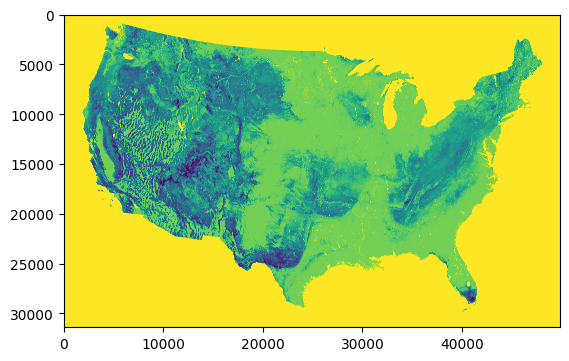

In [8]:
anylithic_p = "anylithicdpt_cm_p.tif"
img = plt.imread(os.path.join(DATA_BASE_PATH, anylithic_p))
plt.imshow(img)

In [9]:
sample_imagename = file_info_df["filename"].sample(1)

sample_image = plt.imread(sample_imagename)
row_index = file_info_df[file_info_df["filename"] == sample_image].index
scalar = file_info_df["scalar"].loc[row_index].item()

plt.imshow(sample_image / scalar)

### Plot histograms for each value at depth 0

100%|██████████| 20/20 [06:28<00:00, 19.42s/it]


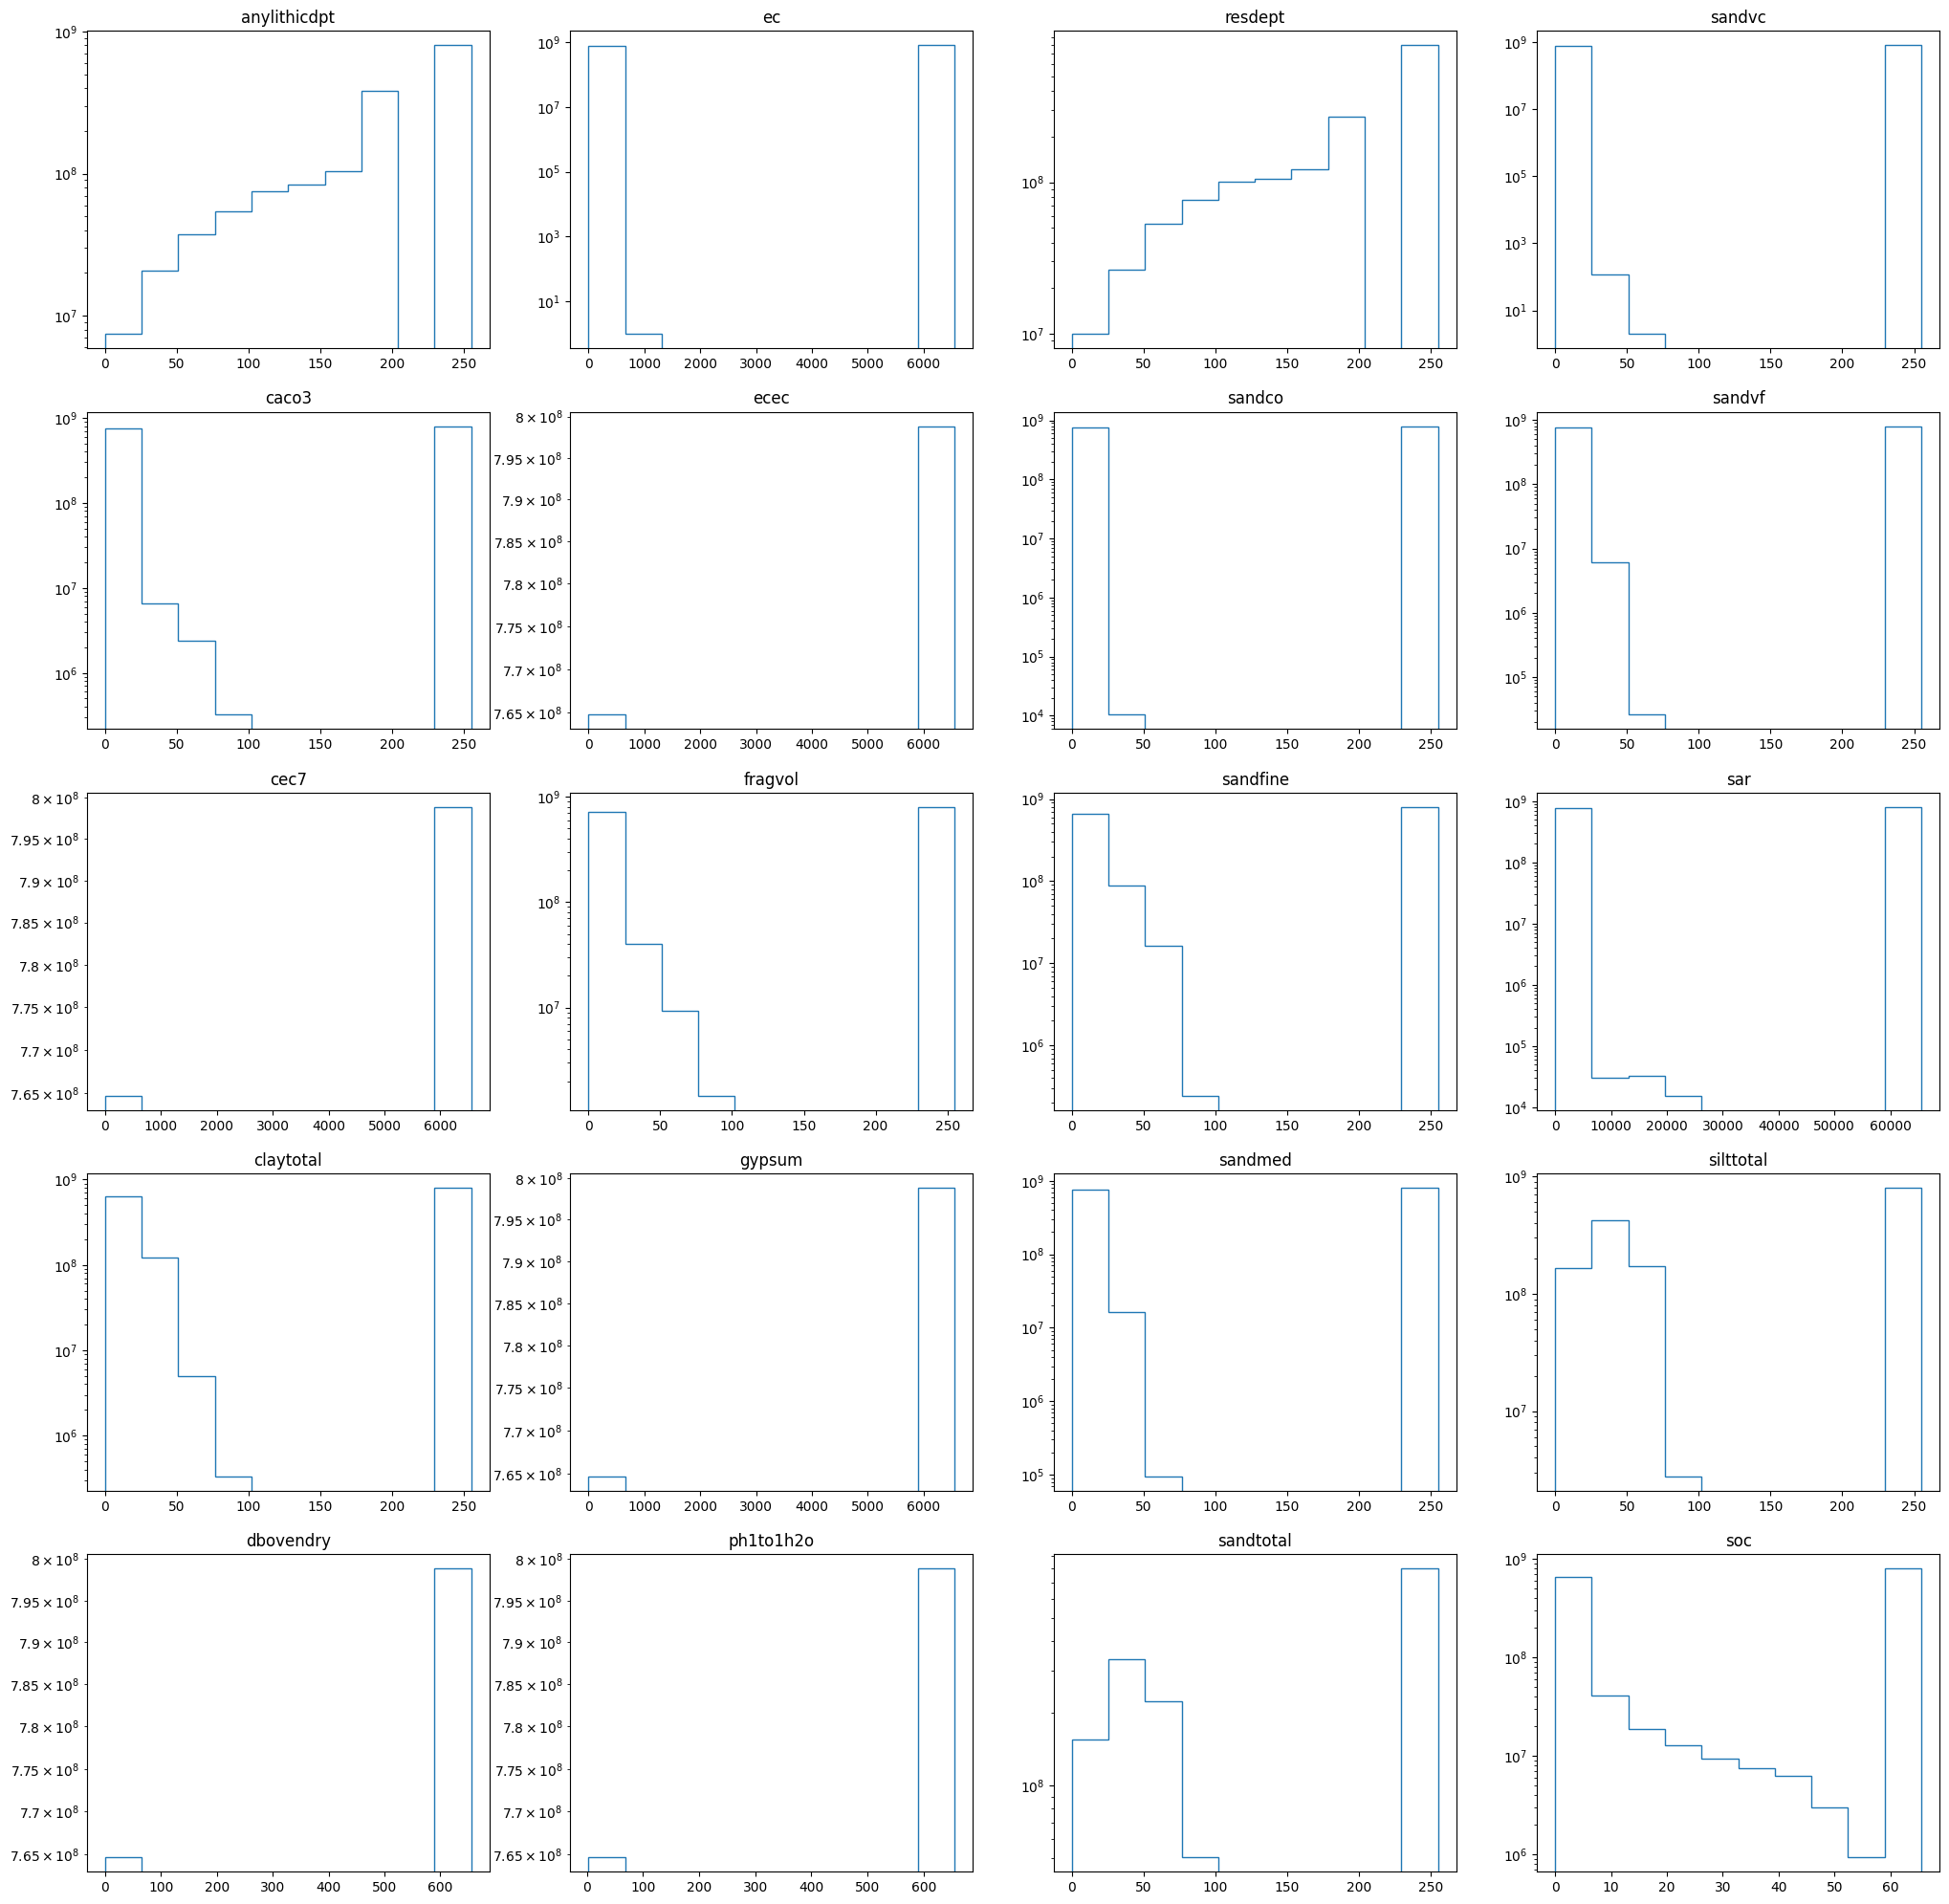

In [11]:
properties = file_info_df["property"].unique()

plot_index = 0

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25, 5 * 5))
plt.yscale("log")

for property in tqdm(properties):
    scalar = 1
    image_name = f"{property}_0_cm_p.tif"

    if property == "anylithicdpt":
        image_name = "anylithicdpt_cm_p.tif"
    elif property == "resdept":
        image_name = "resdept_all_cm_p.tif"
    else:
        row_index = file_info_df[file_info_df["filename"] == image_name].index
        scalar = file_info_df["scalar"].loc[row_index].item()   
    img = plt.imread(os.path.join(DATA_BASE_PATH, image_name))

    counts, bins = np.histogram(img.flatten() / scalar)

    x = plot_index % 5
    y = plot_index // 5

    axes[x, y].stairs(counts, bins)
    axes[x, y].set_yscale('log')
    axes[x, y].set_title(property)

    plot_index += 1


# Modeling

### Idea: 

* Based on data analysis, a large skew exists (regions without data are labeled as the max value). To correct for this, a mask is applied in the data preprocessing. 
* Start simple by using other features [x1, x2, ..., xn] to predict target property y.

    * Advantages: Each individual data example is small. This is useful for quick prototyping and will set a baseline for future experiments.
    * Small data dimensionality means larger batch sizes can be used.

* Data files are large and loading all to memory is prohibitive. Instead, load data in chunks where each chunk is a subset of the rows in the data.
    * Each chunk is cached since each chunk contains many individal data examples. The dimensionality is (Width of row x chunk height).

In [251]:
class Solus100PixelFeatures(Dataset):
    def __init__(self, base_path: str, file_info_df: pd.DataFrame, features: List[str], labels: List[str], chunk_split: List[int]=None):
        """Torch Dataset of Solus100

        Args:
            base_path (str): Base path of data
            file_info_df (pd.DataFrame): Pandas dataframe mapping filenames to scalar
            features (List[str]): List of filenames to load for data features
            labels (List[str]): List of filenames to load for the target variable
            chunk_split (List[int]): List of indices denoting a subset of chunks to load
        """
        anylithic_p = "anylithicdpt_cm_p.tif"
        DATA_BASE_PATH = base_path
        self.CHUNK_SIZE = 1000
        self.file_info_df = file_info_df

        # Split height by chunk size (CHUNK_SIZE)
        if chunk_split is None:
            chunk_split = range(math.floor(HEIGHT / self.CHUNK_SIZE))
        else:
            chunk_split = sorted(chunk_split)

        self.data_indices_per_chunk = []
        pyvips_image = pyvips.Image.new_from_file(os.path.join(DATA_BASE_PATH, anylithic_p))

        # Use mask to get indices of valid examples, per chunk
        for i in chunk_split:
            chunk_pvips = pyvips_image.crop(0, i * self.CHUNK_SIZE, WIDTH, self.CHUNK_SIZE)
            chunk = chunk_pvips.numpy()
            self.data_indices_per_chunk.append(chunk != 255)

        self.chunk_size_masked = [np.sum(indices) for indices in self.data_indices_per_chunk]

        self.len = np.sum(self.chunk_size_masked)

        # Calculate size of each row 
        row_sizes = np.array([np.sum(indices) for indices in self.data_indices_per_chunk])
        self.cum_sum_row_sizes = np.cumsum(row_sizes) - 1

        self.features = features
        self.labels = labels

        self.all_images = self.features + self.labels

        # Load all images using pyvips
        self.pyvips_images = [pyvips.Image.new_from_file(os.path.join(DATA_BASE_PATH, image)) for image in self.all_images]

        self.cached_chunk_index = None
        self.cached_features = None
        self.chunk_split = chunk_split

    def __len__(self):
        return self.len

    def __getitem__(self, idx: int):
        """Get individual data item. Item index is mapped to corresponding chunk and index in chunk. 
        """
        subset_index = 0
        for i in range(len(self.cum_sum_row_sizes)):
            if idx <= self.cum_sum_row_sizes[i] and (idx > self.cum_sum_row_sizes[i - 1] or i == 0):
                chunk_index = self.chunk_split[i]
                subset_index = i
        
        chunk_length = self.chunk_size_masked[subset_index]
        num_features = len(self.features)

        features_per_chunk = np.zeros((len(self.features) + len(self.labels), chunk_length))

        # If the chunk containing the requested data item is cached
        if self.cached_chunk_index == chunk_index:
            features_per_chunk = self.cached_features

        # Else load requested item from chunk
        else:
            row_index = 0
            for j, (image_name, pyvips_image) in enumerate(zip(self.all_images, self.pyvips_images)):
                chunk_pvips = pyvips_image.crop(0, chunk_index * self.CHUNK_SIZE, WIDTH, self.CHUNK_SIZE)
                chunk = chunk_pvips.numpy()

                row_index = self.file_info_df[self.file_info_df["filename"] == image_name].index
                scalar = self.file_info_df["scalar"].loc[row_index].item()

                features_per_chunk[j] = chunk[self.data_indices_per_chunk[subset_index]] / (scalar * 10)

            self.cached_chunk_index = chunk_index
            self.cached_features = features_per_chunk

        if subset_index > 0:
            column_idx = self.cum_sum_row_sizes[subset_index - 1] - idx
        else:
            column_idx = idx
        
        x = features_per_chunk[0:num_features, column_idx]
        y = features_per_chunk[num_features, column_idx]

        return torch.tensor(x).to(torch.float32), torch.tensor(y).to(torch.float32)


## Setup Data

In [252]:
features = ["claytotal_0_cm_p.tif", "silttotal_0_cm_p.tif", "sandtotal_0_cm_p.tif"]
label = ["soc_0_cm_p.tif"]

chunk_idxs = [i for i in range(math.floor(HEIGHT / 1000))]
splits = np.random.choice(chunk_idxs, (3, 10), replace=False)

In [253]:
train_dataset = Solus100PixelFeatures(DATA_BASE_PATH, file_info_df, features, label, splits[0])
val_dataset = Solus100PixelFeatures(DATA_BASE_PATH, file_info_df, features, label, splits[1])
test_dataset = Solus100PixelFeatures(DATA_BASE_PATH, file_info_df, features, label, splits[2])

In [254]:
batch_size = int(5e4)
test_batch_size = int(5e4)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
test_data_loader = DataLoader(val_dataset, batch_size=test_batch_size)

In [255]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size: int):
        super(LinearClassifier, self).__init__()

        hidden_size = 128
        self.linear = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.linear(x)


In [256]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LinearClassifier(3).to(device)

## Train Model

In [257]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)
epochs = 10
batches_per_epoch = 10

In [258]:
epoch_losses = {"train": [], "val": []}
for epoch in tqdm(range(epochs)):
    model.train()

    running_losses = {"train": 0, "val": 0}

    # Train model
    train_dataloader_iter = iter(train_data_loader)
    for batch_idx in range(batches_per_epoch):
        batch = next(train_dataloader_iter)
        data_batch, label_batch = batch

        data_batch = data_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()

        outputs = model(data_batch)

        loss = loss_fn(torch.squeeze(outputs), torch.squeeze(label_batch))
        loss.backward()
        optimizer.step()

        running_losses["train"] += loss.item()

    # Run validation
    with torch.no_grad():
        val_dataloader_iter = iter(val_data_loader)
        for batch_idx in range(batches_per_epoch):
            model.eval()
            
            batch = next(val_dataloader_iter)
            data_batch, label_batch = batch

            data_batch = data_batch.to(device)
            label_batch = label_batch.to(device)

            outputs = model(data_batch)

            loss = loss_fn(torch.squeeze(outputs), torch.squeeze(label_batch))

            running_losses["val"] += loss.item()


    train_loss = running_losses["train"] / batches_per_epoch
    val_loss = running_losses["val"] / batches_per_epoch

    epoch_losses["train"].append(train_loss)
    epoch_losses["val"].append(val_loss)


100%|██████████| 10/10 [03:47<00:00, 22.77s/it]


## Plot train and validation loss

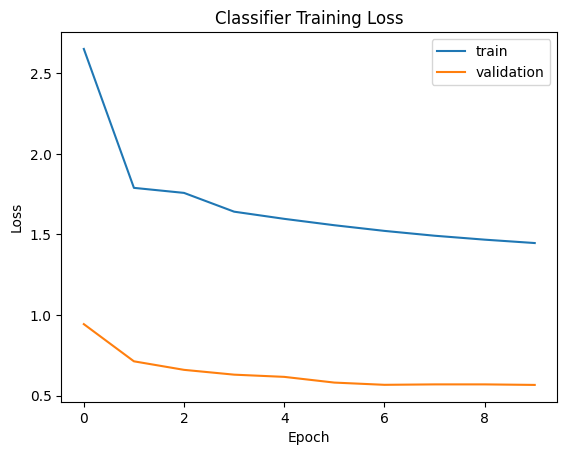

In [259]:
plt.plot(epoch_losses["train"], label="train")
plt.plot(epoch_losses["val"], label="validation")
plt.title("Classifier Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Evaluating on holdout test set

In [260]:
model.eval()

loss_fn = nn.MSELoss()
batch_losses = []
with torch.no_grad():
    test_dataloader_iter = iter(test_data_loader)
    for batch_idx in tqdm(range(batches_per_epoch)):
        batch = next(test_dataloader_iter)

        data_batch, label_batch = batch
        data_batch = data_batch.to(device)
        label_batch = label_batch.to(device)

        output = model(data_batch)

        loss = loss_fn(output.squeeze(), label_batch.squeeze())

        batch_losses.append(loss.item())

test_loss = sum(batch_losses) / len(batch_losses)
print(f"Test loss: {test_loss}" )

100%|██████████| 10/10 [00:08<00:00,  1.11it/s]

Test loss: 0.5668348908424378


## Observations
Trained on very small subset of data, leaves potential for improved performance with greater training.